In [1]:
#| default_exp models.nbeats

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

# NBEATS

The Neural Basis Expansion Analysis (`NBEATS`) is an `MLP`-based deep neural architecture with backward and forward residual links. The network has two variants: (1) in its interpretable configuration, `NBEATS` sequentially projects the signal into polynomials and harmonic basis to learn trend and seasonality components; (2) in its generic configuration, it substitutes the polynomial and harmonic basis for identity basis and larger network's depth. The Neural Basis Expansion Analysis with Exogenous (`NBEATSx`), incorporates projections to exogenous temporal variables available at the time of the prediction.

This method proved state-of-the-art performance on the M3, M4, and Tourism Competition datasets, improving accuracy by 3% over the `ESRNN` M4 competition winner.

**References**<br>
-[Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2019). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting".](https://arxiv.org/abs/1905.10437)

![Figure 1. Neural Basis Expansion Analysis.](imgs_models/nbeats.png)

In [3]:
#| export
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

In [4]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series

import matplotlib.pyplot as plt

In [5]:
#| exporti
class IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int,
                 out_features: int=1):
        super().__init__()
        self.out_features = out_features
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size
 
    def forward(self, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        backcast = theta[:, :self.backcast_size]
        forecast = theta[:, self.backcast_size:]
        forecast = forecast.reshape(len(forecast), -1, self.out_features)
        return backcast, forecast

class TrendBasis(nn.Module):
    def __init__(self, degree_of_polynomial: int,
                 backcast_size: int, forecast_size: int,
                 out_features: int=1):
        super().__init__()
        self.out_features = out_features
        polynomial_size = degree_of_polynomial + 1
        self.backcast_basis = nn.Parameter(
            torch.tensor(np.concatenate([np.power(np.arange(backcast_size, dtype=float) / backcast_size, i)[None, :]
                                    for i in range(polynomial_size)]), dtype=torch.float32), requires_grad=False)
        self.forecast_basis = nn.Parameter(
            torch.tensor(np.concatenate([np.power(np.arange(forecast_size, dtype=float) / forecast_size, i)[None, :]
                                    for i in range(polynomial_size)]), dtype=torch.float32), requires_grad=False)
    
    def forward(self, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        polynomial_size = self.forecast_basis.shape[0] # [polynomial_size, L+H]
        backcast_theta = theta[:, :polynomial_size]
        forecast_theta = theta[:, polynomial_size:]
        forecast_theta = forecast_theta.reshape(len(forecast_theta),polynomial_size,-1)
        backcast = torch.einsum('bp,pt->bt', backcast_theta, self.backcast_basis)
        forecast = torch.einsum('bpq,pt->btq', forecast_theta, self.forecast_basis)
        return backcast, forecast

class SeasonalityBasis(nn.Module):
    def __init__(self, harmonics: int, 
                 backcast_size: int, forecast_size: int,
                 out_features: int=1):
        super().__init__()
        self.out_features = out_features
        frequency = np.append(np.zeros(1, dtype=float),
                                        np.arange(harmonics, harmonics / 2 * forecast_size,
                                                    dtype=float) / harmonics)[None, :]
        backcast_grid = -2 * np.pi * (
                np.arange(backcast_size, dtype=float)[:, None] / forecast_size) * frequency
        forecast_grid = 2 * np.pi * (
                np.arange(forecast_size, dtype=float)[:, None] / forecast_size) * frequency

        backcast_cos_template = torch.tensor(np.transpose(np.cos(backcast_grid)), dtype=torch.float32)
        backcast_sin_template = torch.tensor(np.transpose(np.sin(backcast_grid)), dtype=torch.float32)
        backcast_template = torch.cat([backcast_cos_template, backcast_sin_template], dim=0)

        forecast_cos_template = torch.tensor(np.transpose(np.cos(forecast_grid)), dtype=torch.float32)
        forecast_sin_template = torch.tensor(np.transpose(np.sin(forecast_grid)), dtype=torch.float32)
        forecast_template = torch.cat([forecast_cos_template, forecast_sin_template], dim=0)

        self.backcast_basis = nn.Parameter(backcast_template, requires_grad=False)
        self.forecast_basis = nn.Parameter(forecast_template, requires_grad=False)

    def forward(self, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        harmonic_size = self.forecast_basis.shape[0] # [harmonic_size, L+H]
        backcast_theta = theta[:, :harmonic_size]
        forecast_theta = theta[:, harmonic_size:]
        forecast_theta = forecast_theta.reshape(len(forecast_theta),harmonic_size,-1)
        backcast = torch.einsum('bp,pt->bt', backcast_theta, self.backcast_basis)
        forecast = torch.einsum('bpq,pt->btq', forecast_theta, self.forecast_basis)
        return backcast, forecast

In [6]:
#| exporti
ACTIVATIONS = ['ReLU',
               'Softplus',
               'Tanh',
               'SELU',
               'LeakyReLU',
               'PReLU',
               'Sigmoid']

class NBEATSBlock(nn.Module):
    """
    N-BEATS block which takes a basis function as an argument.
    """
    def __init__(self, 
                 input_size: int,
                 n_theta: int, 
                 mlp_units: list,
                 basis: nn.Module, 
                 dropout_prob: float, 
                 activation: str):
        """
        """
        super().__init__()

        self.dropout_prob = dropout_prob
        
        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        activ = getattr(nn, activation)()
        
        hidden_layers = [nn.Linear(in_features=input_size, 
                                   out_features=mlp_units[0][0])]
        for layer in mlp_units:
            hidden_layers.append(nn.Linear(in_features=layer[0], 
                                           out_features=layer[1]))
            hidden_layers.append(activ)

            if self.dropout_prob>0:
                raise NotImplementedError('dropout')
                #hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=mlp_units[-1][1], out_features=n_theta)]
        layers = hidden_layers + output_layer
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta)
        return backcast, forecast

In [7]:
#| export
class NBEATS(BaseWindows):
    """ NBEATS

    The Neural Basis Expansion Analysis for Time Series (NBEATS), is a simple and yet
    effective architecture, it is built with a deep stack of MLPs with the doubly 
    residual connections. It has a generic and interpretable architecture depending
    on the blocks it uses. Its interpretable architecture is recommended for scarce
    data settings, as it regularizes its predictions through projections unto harmonic
    and trend basis well-suited for most forecasting tasks.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
    `n_harmonics`: int, Number of harmonic terms for seasonality stack type. Note that len(n_harmonics) = len(stack_types). Note that it will only be used if a seasonality stack is used.<br>
    `n_polynomials`: int, polynomial degree for trend stack. Note that len(n_polynomials) = len(stack_types). Note that it will only be used if a trend stack is used.<br>
    `stack_types`: List[str], List of stack types. Subset from ['seasonality', 'trend', 'identity'].<br>
    `n_blocks`: List[int], Number of blocks for each stack. Note that len(n_blocks) = len(stack_types).<br>
    `mlp_units`: List[List[int]], Structure of hidden layers for each stack type. Each internal list should contain the number of units of each hidden layer. Note that len(n_hidden) = len(stack_types).<br>
    `dropout_prob_theta`: float, Float between (0, 1). Dropout for N-BEATS basis.<br>
    `shared_weights`: bool, If True, all blocks within each stack will share parameters. <br>
    `activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `learning_rate`: float, initial optimization learning rate (0,1).<br>
    `batch_size`: int, number of different series in each batch.<br>
    `windows_batch_size`: int=None, windows sampled from rolled data, default uses all.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str, type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

    **References:**<br>
    -[Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2019). 
    "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting".](https://arxiv.org/abs/1905.10437)
    """
    def __init__(self,
                 h,
                 input_size,
                 n_harmonics: int = 2,
                 n_polynomials: int = 2,
                 stack_types: list = ['identity', 'trend', 'seasonality'],
                 n_blocks: list = [1, 1, 1],
                 mlp_units: list = 3 * [[512, 512]],
                 dropout_prob_theta: float = 0.,
                 activation: str = 'ReLU',
                 shared_weights: bool = False,                 
                 loss=MAE(),
                 learning_rate: float = 1e-3,
                 batch_size: int = 32,
                 windows_batch_size: int = 1024,
                 step_size: int = 1,
                 scaler_type=None,
                 random_seed=1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 **trainer_kwargs):

        # Inherit BaseWindows class
        super(NBEATS, self).__init__(h=h,
                                     input_size=input_size,
                                     loss=loss,
                                     learning_rate=learning_rate,
                                     batch_size=batch_size,
                                     windows_batch_size=windows_batch_size,
                                     step_size=step_size,
                                     scaler_type=scaler_type,
                                     num_workers_loader=num_workers_loader,
                                     drop_last_loader=drop_last_loader,
                                     random_seed=random_seed,
                                     **trainer_kwargs)

        # Architecture
        blocks = self.create_stack(h=h,
                                   input_size=input_size,
                                   stack_types=stack_types, 
                                   n_blocks=n_blocks,
                                   mlp_units=mlp_units,
                                   dropout_prob_theta=dropout_prob_theta,
                                   activation=activation,
                                   shared_weights=shared_weights,
                                   n_polynomials=n_polynomials, 
                                   n_harmonics=n_harmonics)
        self.blocks = torch.nn.ModuleList(blocks)

    def create_stack(self, stack_types, 
                     n_blocks, 
                     input_size, 
                     h, 
                     mlp_units, 
                     dropout_prob_theta, 
                     activation, shared_weights,
                     n_polynomials, n_harmonics):                     

        block_list = []
        for i in range(len(stack_types)):
            for block_id in range(n_blocks[i]):

                # Shared weights
                if shared_weights and block_id>0:
                    nbeats_block = block_list[-1]
                else:
                    if stack_types[i] == 'seasonality':
                        n_theta = 2 * (self.loss.outputsize_multiplier + 1) * \
                                  int(np.ceil(n_harmonics / 2 * h) - (n_harmonics - 1))
                        basis = SeasonalityBasis(harmonics=n_harmonics,
                                                 backcast_size=input_size,forecast_size=h,
                                                 out_features=self.loss.outputsize_multiplier)

                    elif stack_types[i] == 'trend':
                        n_theta = (self.loss.outputsize_multiplier + 1) * (n_polynomials + 1)
                        basis = TrendBasis(degree_of_polynomial=n_polynomials,
                                           backcast_size=input_size,forecast_size=h,
                                           out_features=self.loss.outputsize_multiplier)

                    elif stack_types[i] == 'identity':
                        n_theta = input_size + self.loss.outputsize_multiplier * h
                        basis = IdentityBasis(backcast_size=input_size, forecast_size=h,
                                              out_features=self.loss.outputsize_multiplier)
                    else:
                        raise ValueError(f'Block type {stack_types[i]} not found!')

                    nbeats_block = NBEATSBlock(input_size=input_size,
                                               n_theta=n_theta,
                                               mlp_units=mlp_units,
                                               basis=basis,
                                               dropout_prob=dropout_prob_theta,
                                               activation=activation)

                # Select type of evaluation and apply it to all layers of block
                block_list.append(nbeats_block)
                
        return block_list

    def forward(self, windows_batch):
        
        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        insample_mask = windows_batch['insample_mask']

        # NBEATS' forward
        residuals = insample_y.flip(dims=(-1,)) # backcast init
        insample_mask = insample_mask.flip(dims=(-1,))
        
        forecast = insample_y[:, -1:, None] # Level with Naive1
        block_forecasts = [ forecast.repeat(1, self.h, 1) ]
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast

            if self.decompose_forecast:
                block_forecasts.append(block_forecast)

        # Adapting output's domain
        forecast = self.loss.domain_map(forecast)                

        if self.decompose_forecast:
            # (n_batch, n_blocks, h, out_features)
            block_forecasts = torch.stack(block_forecasts)
            block_forecasts = block_forecasts.permute(1,0,2,3)
            block_forecasts = block_forecasts.squeeze(-1) # univariate output
            return block_forecasts
        else:
            return forecast

In [8]:
show_doc(NBEATS)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/nbeats.py#L140){target="_blank" style="float:right; font-size:smaller"}

### NBEATS

>      NBEATS (h, input_size, n_harmonics:int=2, n_polynomials:int=2,
>              stack_types:list=['identity', 'trend', 'seasonality'],
>              n_blocks:list=[1, 1, 1], mlp_units:list=[[512, 512], [512, 512],
>              [512, 512]], dropout_prob_theta:float=0.0, activation:str='ReLU',
>              shared_weights:bool=False, loss=MAE(), learning_rate:float=0.001,
>              batch_size:int=32, windows_batch_size:int=1024, step_size:int=1,
>              scaler_type=None, random_seed=1, num_workers_loader:int=0,
>              drop_last_loader:bool=False, **trainer_kwargs)

NBEATS

The Neural Basis Expansion Analysis for Time Series (NBEATS), is a simple and yet
effective architecture, it is built with a deep stack of MLPs with the doubly 
residual connections. It has a generic and interpretable architecture depending
on the blocks it uses. Its interpretable architecture is recommended for scarce
data settings, as it regularizes its predictions through projections unto harmonic
and trend basis well-suited for most forecasting tasks.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
`n_harmonics`: int, Number of harmonic terms for seasonality stack type. Note that len(n_harmonics) = len(stack_types). Note that it will only be used if a seasonality stack is used.<br>
`n_polynomials`: int, polynomial degree for trend stack. Note that len(n_polynomials) = len(stack_types). Note that it will only be used if a trend stack is used.<br>
`stack_types`: List[str], List of stack types. Subset from ['seasonality', 'trend', 'identity'].<br>
`n_blocks`: List[int], Number of blocks for each stack. Note that len(n_blocks) = len(stack_types).<br>
`mlp_units`: List[List[int]], Structure of hidden layers for each stack type. Each internal list should contain the number of units of each hidden layer. Note that len(n_hidden) = len(stack_types).<br>
`dropout_prob_theta`: float, Float between (0, 1). Dropout for N-BEATS basis.<br>
`shared_weights`: bool, If True, all blocks within each stack will share parameters. <br>
`activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`learning_rate`: float, initial optimization learning rate (0,1).<br>
`batch_size`: int, number of different series in each batch.<br>
`windows_batch_size`: int=None, windows sampled from rolled data, default uses all.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str, type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

**References:**<br>
-[Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2019). 
"N-BEATS: Neural basis expansion analysis for interpretable time series forecasting".](https://arxiv.org/abs/1905.10437)

In [9]:
show_doc(NBEATS.fit, name='NBEATS.fit')

---

### NBEATS.fit

>      NBEATS.fit (dataset, val_size=0, test_size=0)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization. 
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect 
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [10]:
show_doc(NBEATS.predict, name='NBEATS.predict')

---

### NBEATS.predict

>      NBEATS.predict (dataset, test_size=None, step_size=1,
>                      **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

In [11]:
#| hide
import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

<AxesSubplot: xlabel='ds'>

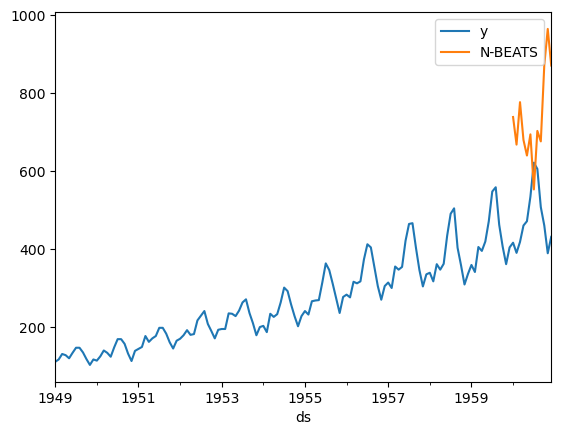

In [12]:
#| hide
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl

from neuralforecast.utils import AirPassengersDF as Y_df
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader

Y_train_df = Y_df[Y_df.ds<Y_df['ds'].values[-12]] # 132 train
Y_test_df = Y_df[Y_df.ds>=Y_df['ds'].values[-12]]   # 12 test

dataset, *_ = TimeSeriesDataset.from_df(df = Y_train_df)
nbeats = NBEATS(h=12, input_size=24, windows_batch_size=None, 
                stack_types=['identity', 'trend', 'seasonality'], max_epochs=1)
nbeats.fit(dataset=dataset)
y_hat = nbeats.predict(dataset=dataset)
Y_test_df['N-BEATS'] = y_hat

pd.concat([Y_train_df, Y_test_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [13]:
#| hide
#test we recover the same forecast
y_hat2 = nbeats.predict(dataset=dataset)
test_eq(y_hat, y_hat2)

Predicting: 0it [00:00, ?it/s]

In [14]:
#| hide
#test no leakage with test_size
dataset, *_ = TimeSeriesDataset.from_df(Y_df)
model = NBEATS(input_size=24, h=12, 
               windows_batch_size=None, max_epochs=1)
model.fit(dataset=dataset, test_size=12)
y_hat_test = model.predict(dataset=dataset, step_size=1)
np.testing.assert_almost_equal(y_hat, y_hat_test, decimal=4)
#test we recover the same forecast
y_hat_test2 = model.predict(dataset=dataset, step_size=1)
test_eq(y_hat_test, y_hat_test2)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

<AxesSubplot: xlabel='ds'>

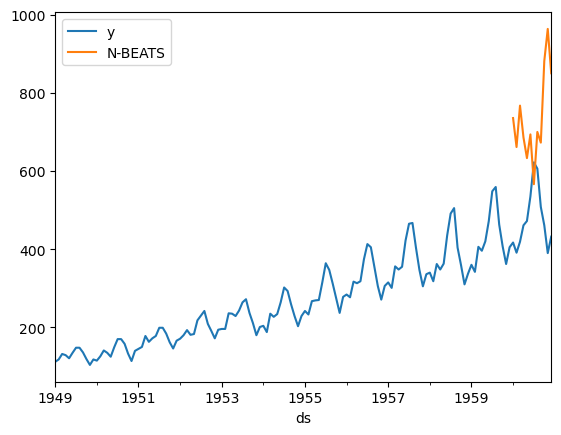

In [15]:
#| hide
# test validation step
dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)
model = NBEATS(input_size=24, h=12, windows_batch_size=None, max_epochs=1)
model.fit(dataset=dataset, val_size=12)
y_hat_w_val = model.predict(dataset=dataset)
Y_test_df['N-BEATS'] = y_hat_w_val

pd.concat([Y_train_df, Y_test_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [16]:
#| hide
# test no leakage with test_size and val_size
dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)
model = NBEATS(input_size=24, h=12, windows_batch_size=None, max_epochs=1)
model.fit(dataset=dataset, val_size=12)
y_hat_w_val = model.predict(dataset=dataset)

dataset, *_ = TimeSeriesDataset.from_df(Y_df)
model = NBEATS(input_size=24, h=12, windows_batch_size=None, max_epochs=1)
model.fit(dataset=dataset, val_size=12, test_size=12)

y_hat_test_w_val = model.predict(dataset=dataset, step_size=1)

np.testing.assert_almost_equal(y_hat_test_w_val, y_hat_w_val, decimal=4)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Text(0.5, 0, 'Prediction τ ∈ {t+1,..., t+H}')

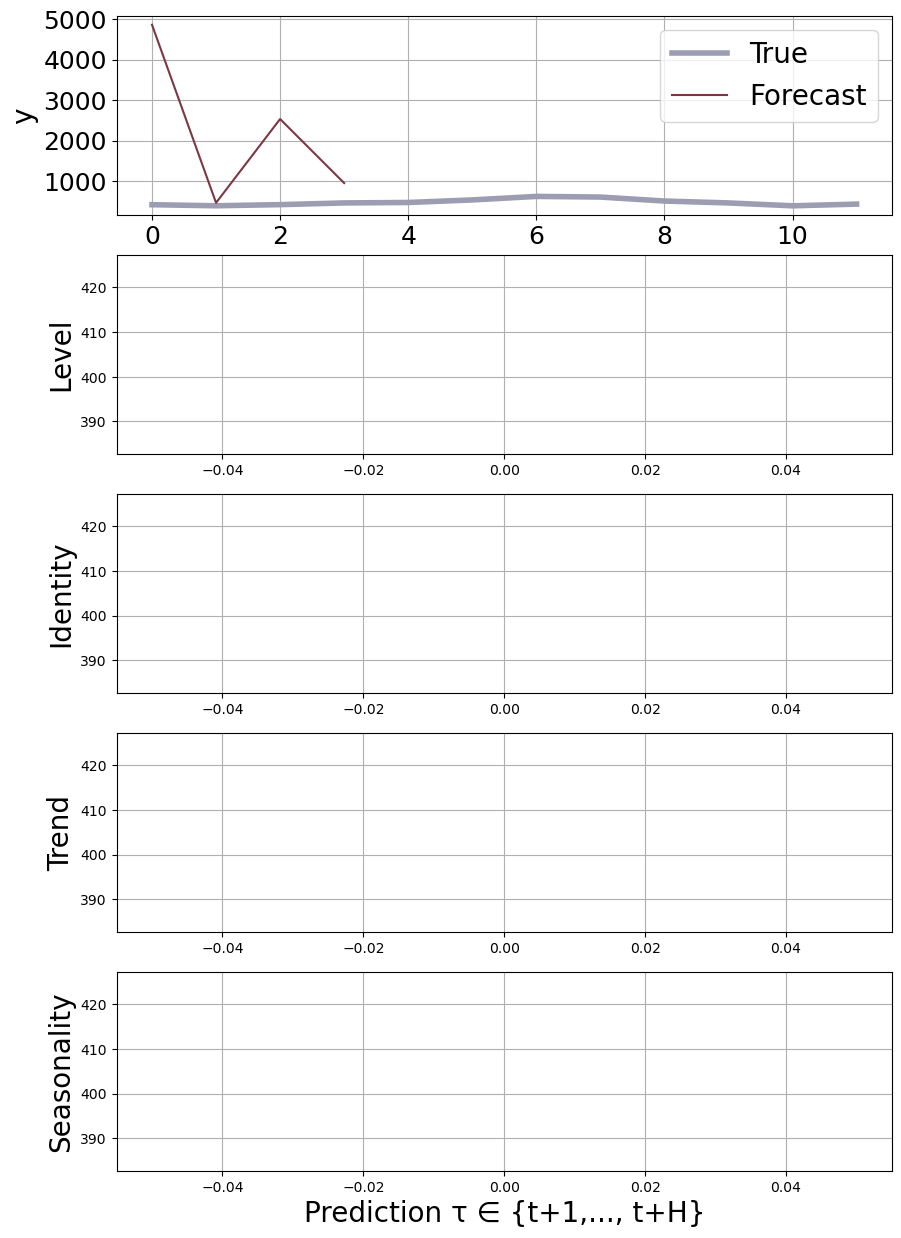

In [17]:
#| hide
# qualitative decomposition evaluation
y_hat = model.decompose(dataset=dataset)

fig, ax = plt.subplots(5, 1, figsize=(10, 15))

ax[0].plot(Y_test_df['y'].values, label='True', color="#9C9DB2", linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten(), label='Forecast', color="#7B3841")
ax[0].grid()
ax[0].legend(prop={'size': 20})
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(18)
ax[0].set_ylabel('y', fontsize=20)

ax[1].plot(y_hat[0,0], label='level', color="#7B3841")
ax[1].grid()
ax[1].set_ylabel('Level', fontsize=20)

ax[2].plot(y_hat[0,1], label='stack1', color="#7B3841")
ax[2].grid()
ax[2].set_ylabel('Identity', fontsize=20)

ax[3].plot(y_hat[0,2], label='stack2', color="#D9AE9E")
ax[3].grid()
ax[3].set_ylabel('Trend', fontsize=20)

ax[4].plot(y_hat[0,3], label='stack3', color="#D9AE9E")
ax[4].grid()
ax[4].set_ylabel('Seasonality', fontsize=20)

ax[4].set_xlabel('Prediction \u03C4 \u2208 {t+1,..., t+H}', fontsize=20)

## Usage Example

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[]

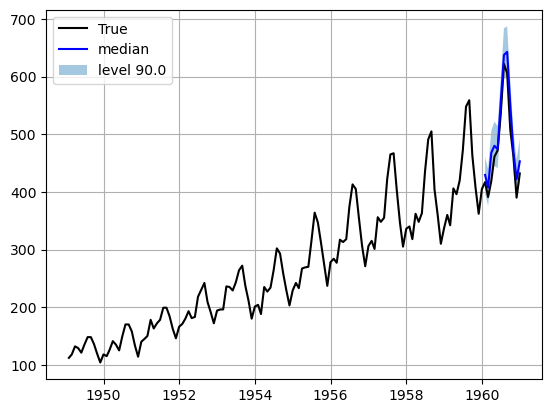

In [19]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = NBEATS(h=12, input_size=24,
               #loss=MQLoss(level=[80, 90]),
               loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
               stack_types = ['identity', 'trend', 'seasonality'],
               max_epochs=100)

fcst = NeuralForecast(
    models=[model],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NBEATS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'], 
                 y1=plot_df['NBEATS-lo-90.0'], y2=plot_df['NBEATS-hi-90.0'],
                 alpha=0.4, label='level 90.0')
plt.grid()
plt.legend()
plt.plot()